# Assignment 4 - Neural Networks

## *Yuanjing Zhu*
Netid: yz792


Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1

## [65 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [11]:
# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

In [2]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

#-----------------------------------------------------------------------------
# Create the data
#-----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n/4)
    shift = 0.5
    c1a = np.random.randn(n_samples,2)*noise + [-shift, shift]
    c1b = np.random.randn(n_samples,2)*noise + [shift, -shift]
    c0a = np.random.randn(n_samples,2)*noise + [shift, shift]
    c0b = np.random.randn(n_samples,2)*noise + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    
    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X)>cutoff
    for index,value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand()*2.5-1.25
    return (X,y)

# Training datasets
np.random.seed(42)
noise = 0.45
X_train,y_train = make_data_normal_checkerboard(500, noise=noise)
    
# Validation and test data
X_val,y_val = make_data_normal_checkerboard(500, noise=noise)
X_test,y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, 
# train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1*np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

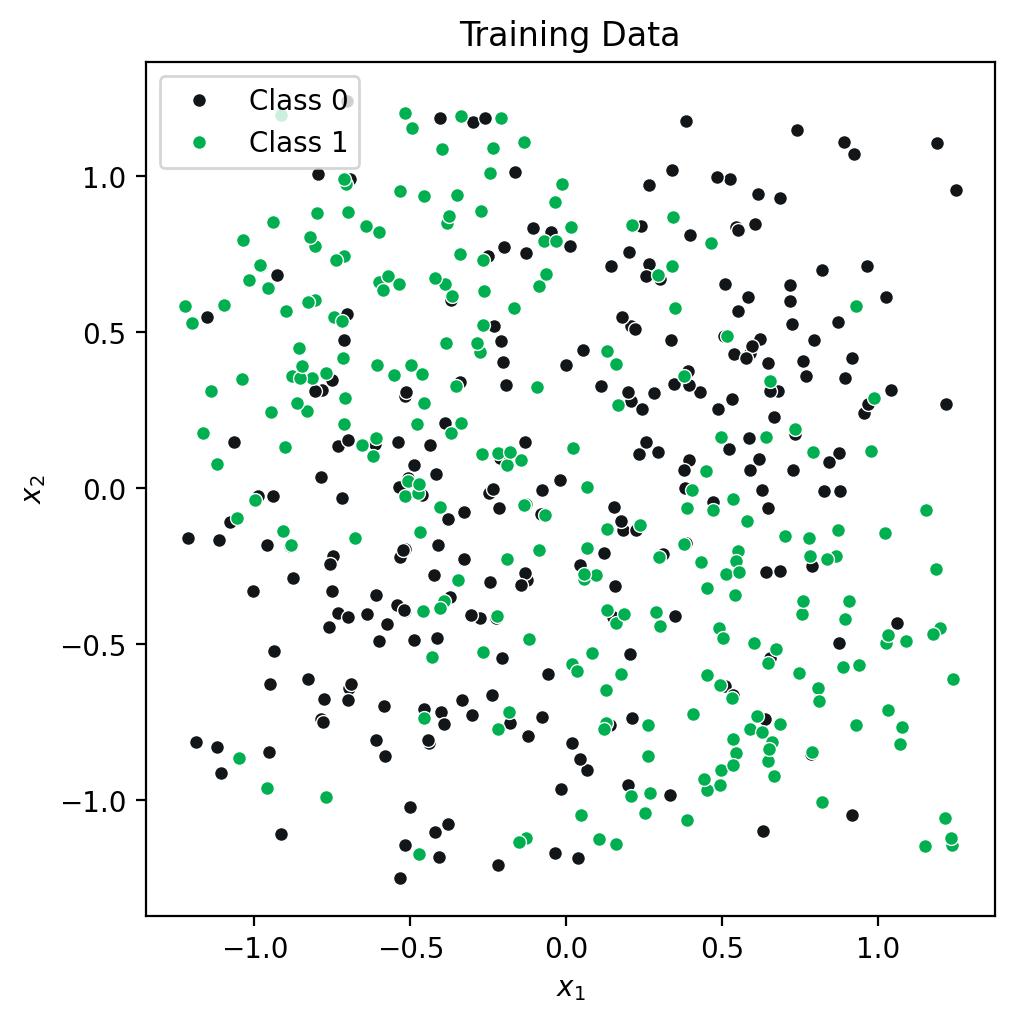

In [3]:
import matplotlib.pyplot as plt

# Code to plot the sample data
def plot_data(ax,X,y,title, limits):
    # Select the colors to use in the plots
    color0 = '#121619' # Dark grey
    color1 = '#00B050' # Green
    color_boundary='#858585'
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='upper left')
    ax.set_aspect('equal')

fig, ax = plt.subplots(constrained_layout=True, figsize=(5,5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, 'Training Data', limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

This should produce 12 plots, altogether. For easier comparison, please plot nodes & layers combinations, learning rates, regularization strengths, and batch sizes in four separate rows (with three columns each representing a different value for each of those hyperparameters). 

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

------------------------------------------------------------------
ANSWER:

In [4]:
from sklearn.neural_network import MLPClassifier

In [5]:
def initialize_MLP(hidden_layer_sizes = (30,30),
                   learning_rate_init = 0.03,
                   alpha = 0,
                   batch_size = 50,
                   random_state = 225):
    '''Fit a neural network model with the given hyperparameters
    Inputs:
        hidden_layer_sizes: tuple of ints, number of nodes in each hidden layer
                            default is (30,30)
        learning_rate_init: learning rate, default is 0.03
        alpha: float, L2 regularization parameter, default is 0
        batch_size: int, number of samples to use in each batch, default is 50
        random_state: int, random seed, default is 225
    '''
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init = learning_rate_init,
                        alpha = alpha,
                        solver = 'sgd',
                        tol = 1e-5,
                        early_stopping = False,
                        activation = 'relu',
                        n_iter_no_change = 1000,
                        batch_size = batch_size,
                        max_iter = 500,
                        random_state = random_state)
    return mlp

In [6]:
# fit models with varying hidden layer
mlp_1_1 = initialize_MLP(hidden_layer_sizes = (2,2)).fit(X_train, y_train)
mlp_1_2 = initialize_MLP(hidden_layer_sizes = (5,5)).fit(X_train, y_train)
mlp_1_3 = initialize_MLP(hidden_layer_sizes = (30,30)).fit(X_train, y_train)

# fit models with varying learning rate
mlp_2_1 = initialize_MLP(learning_rate_init = 0.0001).fit(X_train, y_train)
mlp_2_2 = initialize_MLP(learning_rate_init = 0.01).fit(X_train, y_train)
mlp_2_3 = initialize_MLP(learning_rate_init = 1).fit(X_train, y_train)

# fit models with varying regularization
mlp_3_1 = initialize_MLP(alpha= 0).fit(X_train, y_train)
mlp_3_2 = initialize_MLP(alpha= 1).fit(X_train, y_train)
mlp_3_3 = initialize_MLP(alpha= 10).fit(X_train, y_train)

# fit models with varying batch size
mlp_4_1 = initialize_MLP(batch_size = 5).fit(X_train, y_train)
mlp_4_2 = initialize_MLP(batch_size = 50).fit(X_train, y_train)
mlp_4_3 = initialize_MLP(batch_size = 500).fit(X_train, y_train)

In [7]:
# prepare data for plot
l_xx = []
l_yy = []
l_zz = []
l_mlp = [mlp_1_1, mlp_1_2, mlp_1_3, \
         mlp_2_1, mlp_2_2, mlp_2_3, \
         mlp_3_1, mlp_3_2, mlp_3_3, \
         mlp_4_1, mlp_4_2, mlp_4_3]
l_title = ['Hidden size:(2,2)', 'Hidden size:(5,5)', 'Hidden size:(30,30)', \
            'Learning rate: 0.0001', 'Learning rate: 0.01', 'Learning rate: 1', \
            'Alpha: 0', 'Alpha: 1', 'Alpha: 10', \
            'Batch size: 5', 'Batch size: 50', 'Batch size: 500']

x_min, x_max = X_train[:, 0].min() - 0.2, X_train[:, 0].max() + 0.2
y_min, y_max = X_train[:, 1].min() - 0.2, X_train[:, 1].max() + 0.2
xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
xx_yy = np.c_[xx_train.ravel(), yy_train.ravel()]

for mlp in l_mlp:
    Z_train = mlp.predict(xx_yy)
    Z_train = np.array(Z_train).reshape(xx_train.shape)
    l_xx.append(xx_train)
    l_yy.append(yy_train)
    l_zz.append(Z_train)

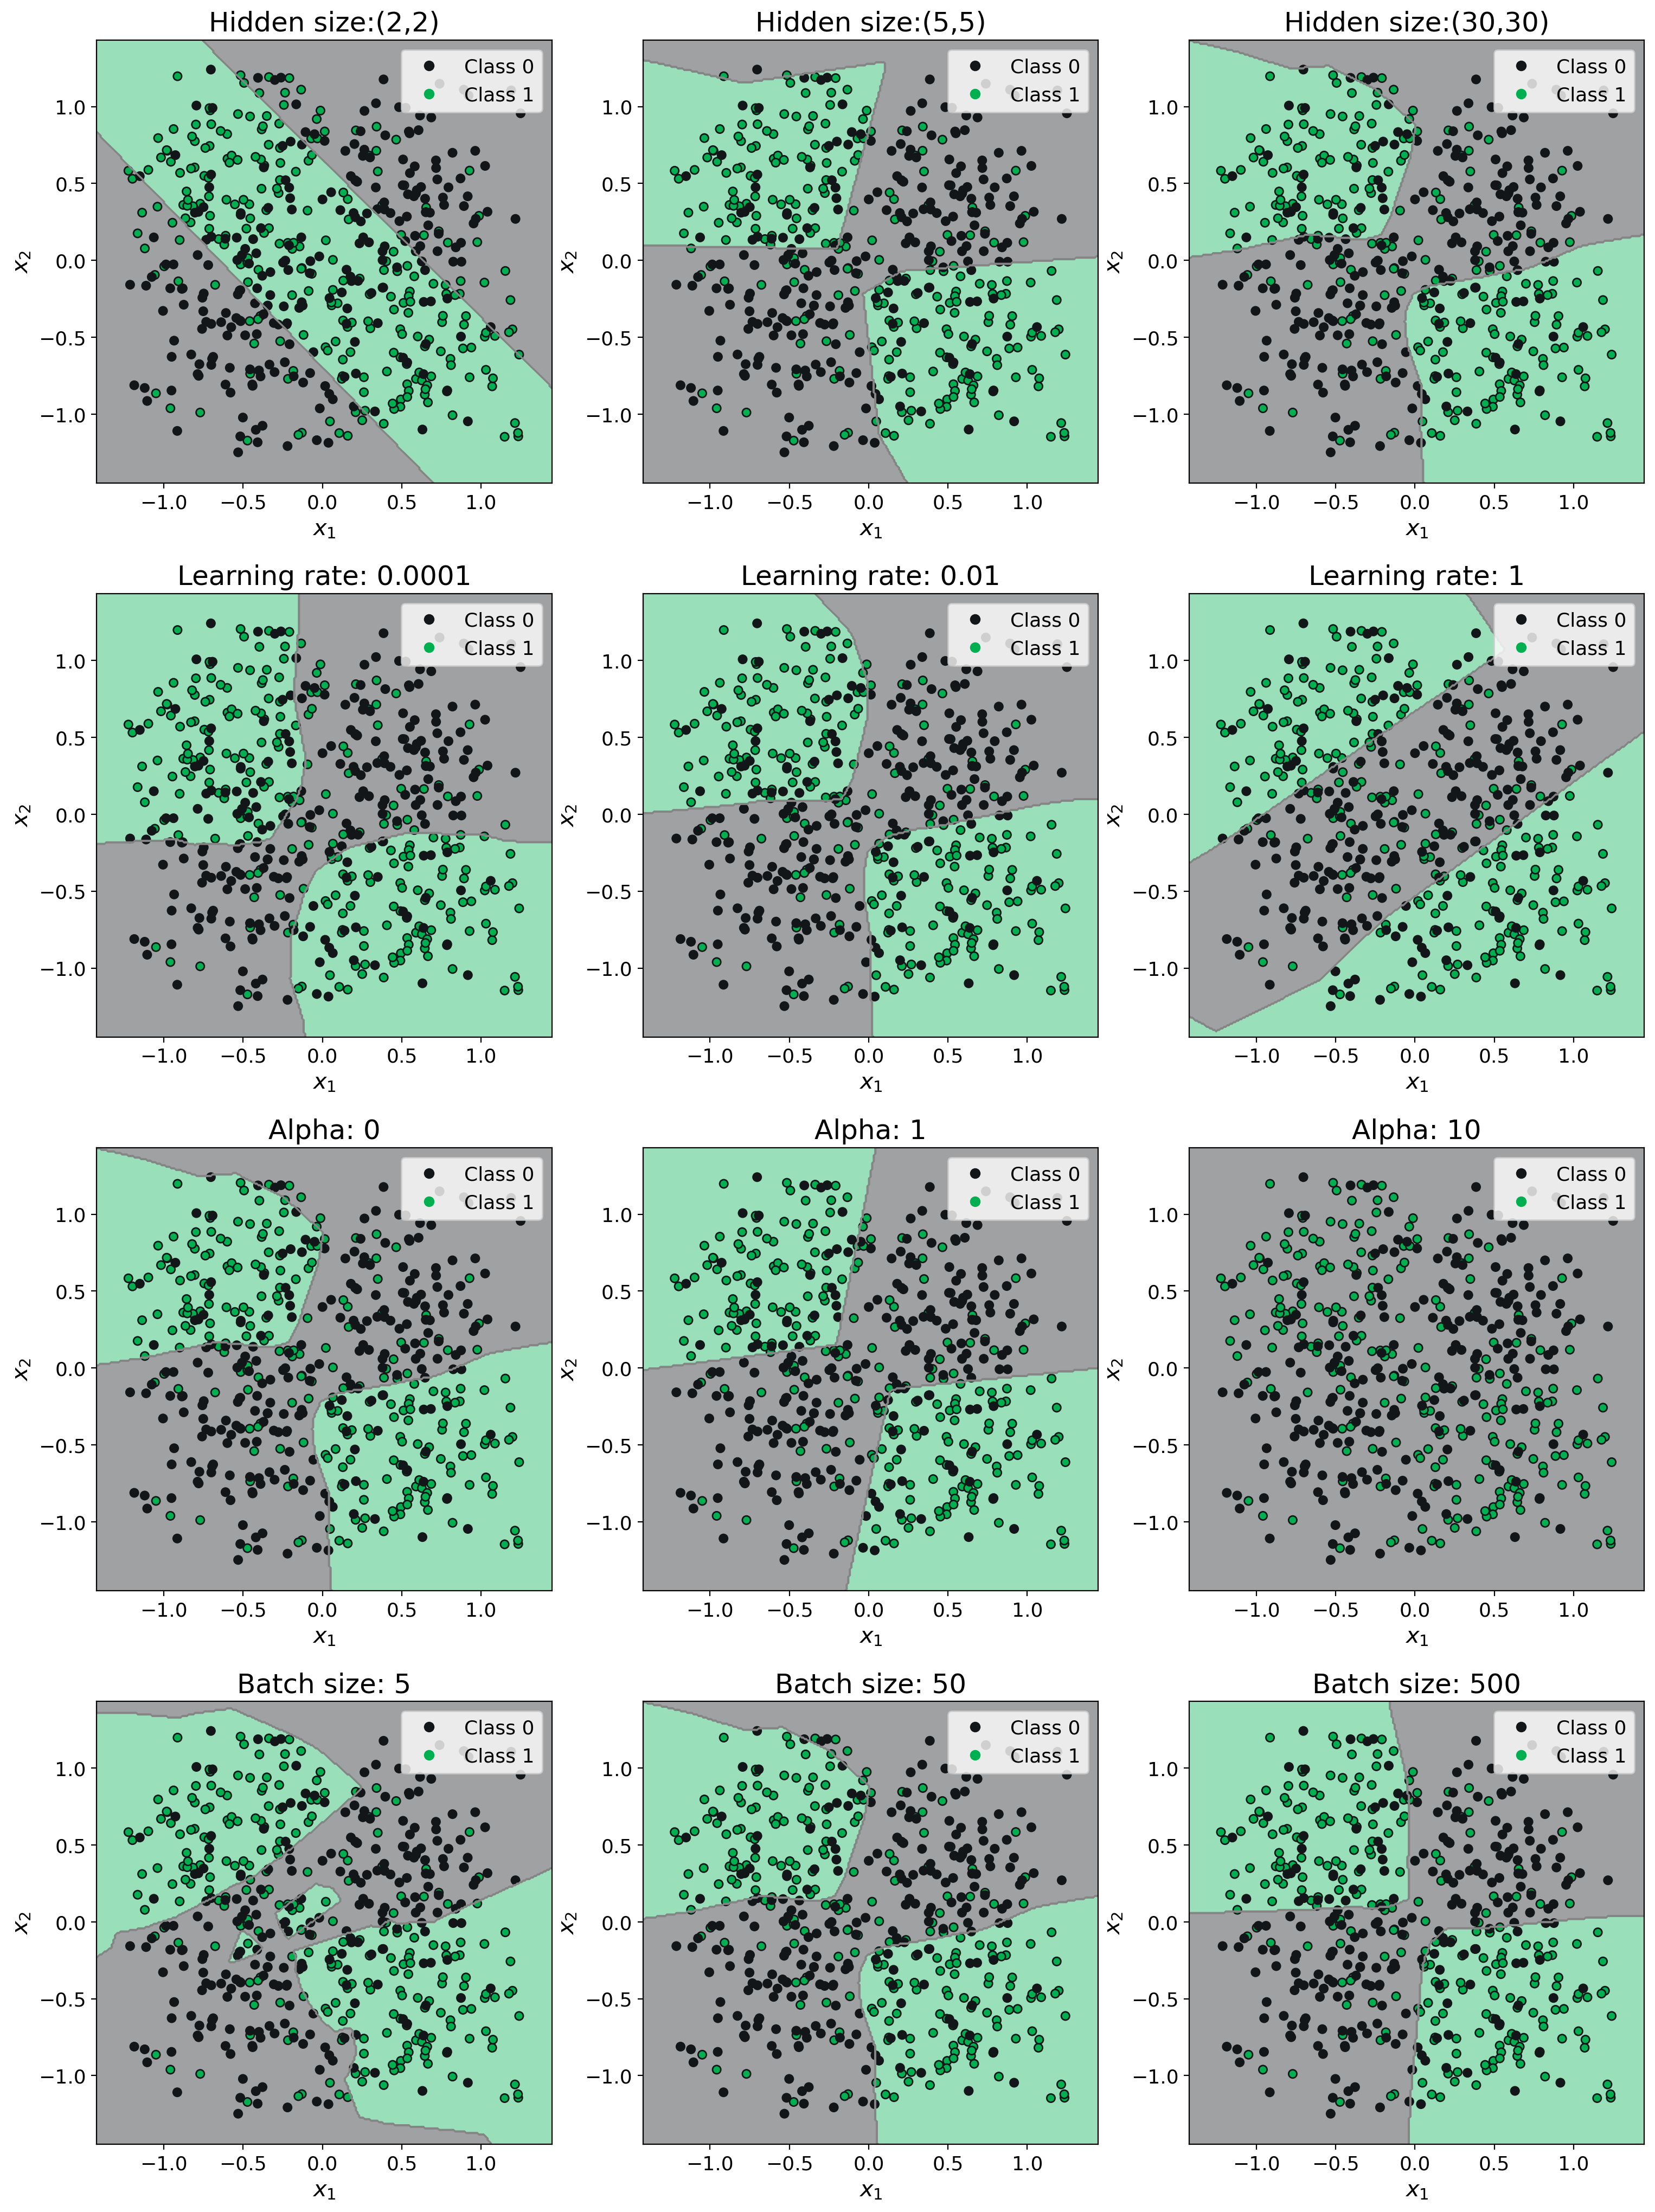

In [8]:
# customise color map
from matplotlib.colors import ListedColormap
colors = ['#121619', '#00B050']
cust_cmap = ListedColormap(colors)

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.25, wspace=0.2)
for ax, xx, yy, zz, title in zip(axs.flat, l_xx, l_yy, l_zz, l_title):
    ax.contour(xx, yy, zz, colors='#858585', linewidths=0.5)
    ax.contourf(xx, yy, zz, alpha=0.4, cmap=cust_cmap)
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], cmap=cust_cmap, \
                         c=y_train, edgecolors='#121619', s=30)
    ax.legend(handles=scatter.legend_elements()[0], 
                 labels=['Class 0', 'Class 1'], fontsize = 13)
    ax.set_title(title, fontsize = 18)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('$x_1$', fontsize = 15)
    ax.set_ylabel('$x_2$', fontsize = 15)
    ax.tick_params(axis='both', labelsize=13)


**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

------------------------------------------------------------------
ANSWER:

In [9]:
# Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
l_scores_lr = []
l_lr = np.logspace(-5, 0, 20)
for i in l_lr:
    mlp = initialize_MLP(learning_rate_init = i)
    mlp.fit(X_train, y_train)
    l_scores_lr.append(mlp.score(X_val, y_val))

# Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
l_scores_alpha = []
l_alpha = np.logspace(-8, 2, 20)
for i in l_alpha:
    mlp = initialize_MLP(alpha = i)
    mlp.fit(X_train, y_train)
    l_scores_alpha.append(mlp.score(X_val, y_val))

# Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$
l_scores_batch = []
l_batch = [1,3,5,10,20,50,100,250,500]
for i in l_batch:
    mlp = initialize_MLP(batch_size = i)
    mlp.fit(X_train, y_train)
    l_scores_batch.append(mlp.score(X_val, y_val))

In [10]:
print(f'Accuracy is largest when learning rate is \
      {l_lr[np.argmax(l_scores_lr)]:.2e}')
print(f'Accuracy is largest when regularization is \
      {l_alpha[np.argmax(l_scores_alpha)]:.2e}')
print(f'Accuracy is largest when batch size is \
      {l_batch[np.argmax(l_scores_batch)]}')

Accuracy is largest when learning rate is 4.28e-03
Accuracy is largest when regularization is 1.13e-07
Accuracy is largest when batch size is 250


In [12]:
def plot_acc_curve(x, y, xtitle, ytitle, title, vline=None):
    '''
    Plot learning curve
    Input:
        x: x-axis data
        y: y-axis data
        label: label of the curve
        xtitle: x-axis title
        ytitle: y-axis title
        title: plot title
        vline: vertical line to be plotted
    Output: None
    '''
    plt.figure(figsize=(7, 5), dpi=100)
    plt.grid('on')
    plt.semilogx(x, y, color='#00B050', linewidth=2)
    if vline:
        plt.axvline(vline, color='r', linestyle='--', ymin=0.65)
    plt.xlabel(xtitle, fontsize=12)
    plt.ylabel(ytitle, fontsize=12)
    plt.title(title, fontsize=13)
    plt.show()    

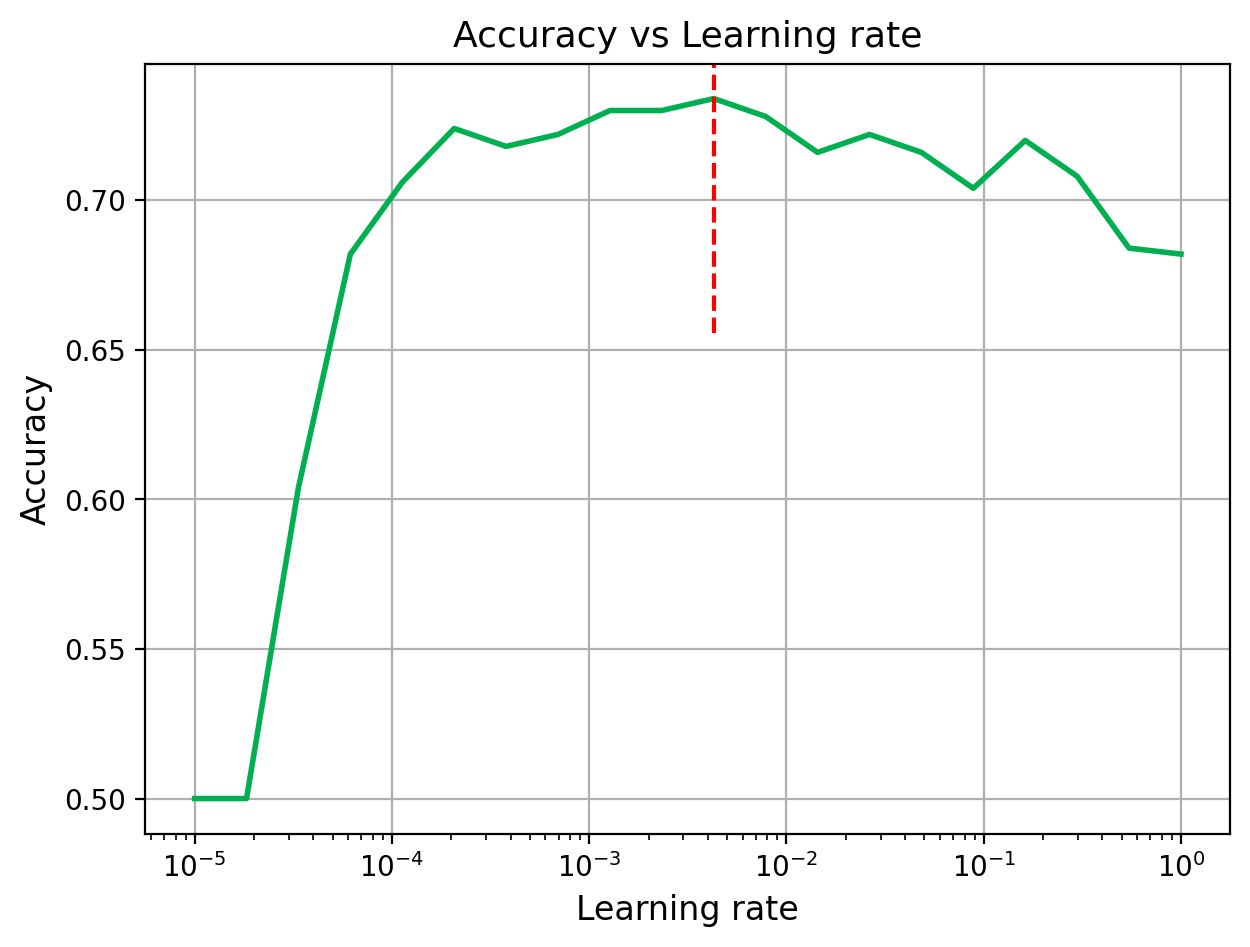

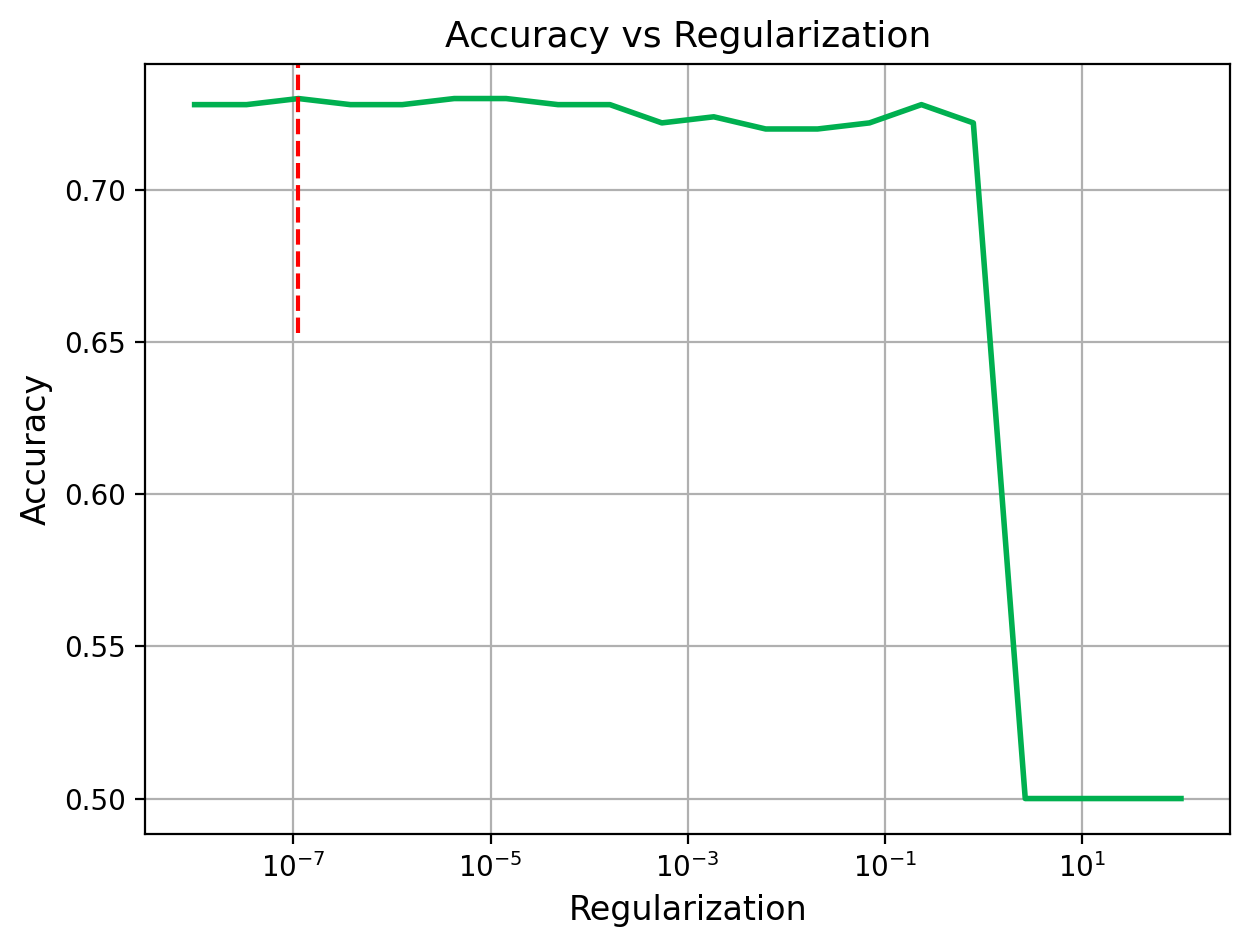

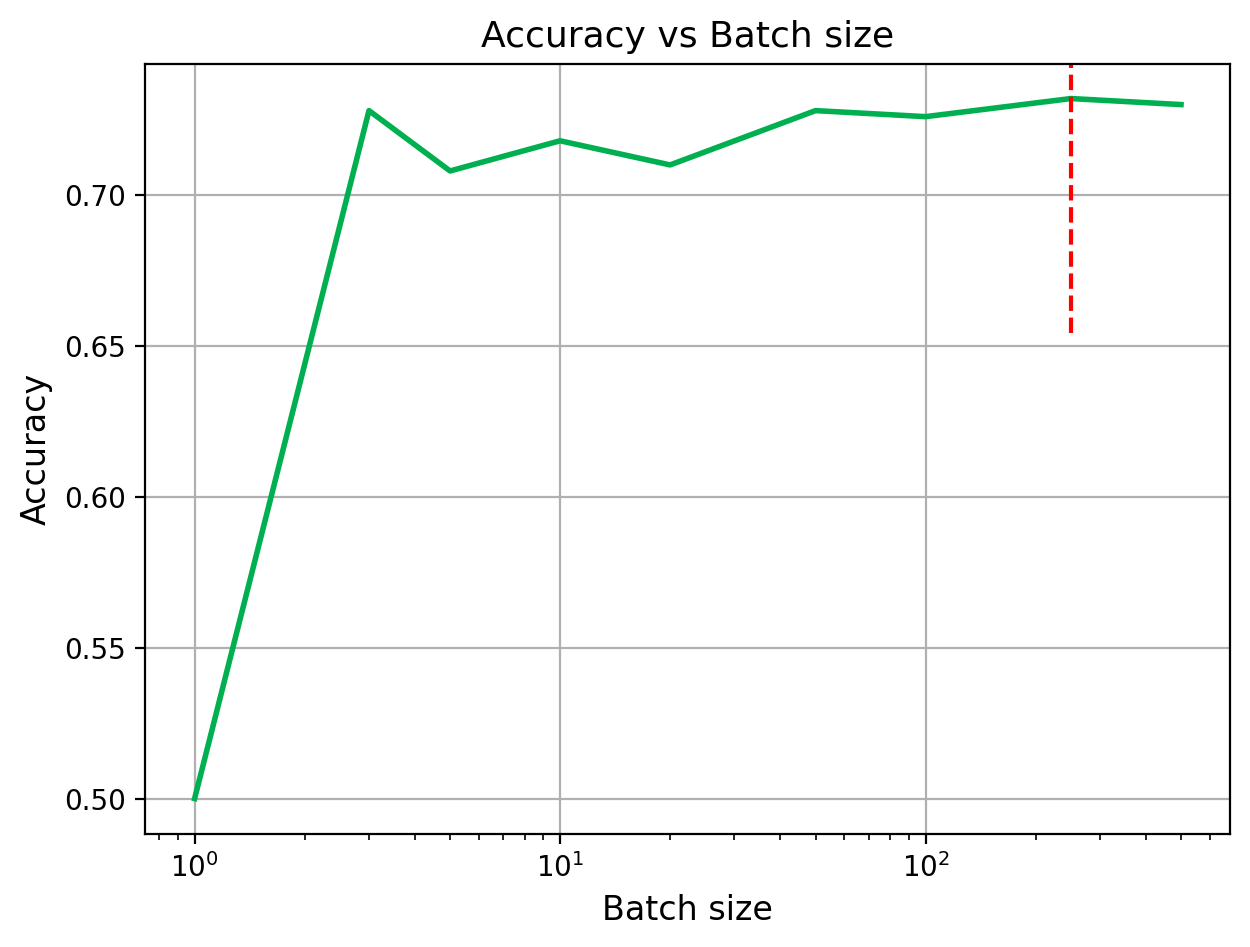

In [13]:
# start plot
plot_acc_curve(l_lr, l_scores_lr, 'Learning rate', 'Accuracy', \
               'Accuracy vs Learning rate', vline=4.28e-03)
plot_acc_curve(l_alpha, l_scores_alpha, 'Regularization', 'Accuracy', \
               'Accuracy vs Regularization', vline=1.13e-07)
plot_acc_curve(l_batch, l_scores_batch, 'Batch size', 'Accuracy', \
               'Accuracy vs Batch size', vline=250)

I didn't fit multiple times because the plots were not very noisy.\
Based on the plots, I chose **learning rate** to be **4.28e-03**, **alpha** for regularization to be **1.13e-07**, and **batch size** to be **250** because the accuracy reaches its maximum at these values and stays relatively constant.

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

------------------------------------------------------------------
ANSWER:

In [14]:
def new_init_MLP(hidden_layer_sizes = (30,30),
                 learning_rate_init = 4.28e-03,
                 alpha = 1.13e-07,
                 batch_size = 250,
                 random_state = 225):
    '''Fit a neural network model with the new hyperparameters after greedy search
    Inputs:
        hidden_layer_sizes: tuple of ints, number of nodes in each hidden layer
                            default is (30,30)
        learning_rate_init: learning rate, default is 0.002
        alpha: float, L2 regularization parameter, default is 0.006
        batch_size: int, number of samples to use in each batch, default is 10
        random_state: int, random seed, default is 225
    '''
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        learning_rate_init = learning_rate_init,
                        alpha = alpha,
                        solver = 'sgd',
                        tol = 1e-5,
                        early_stopping = False,
                        activation = 'relu',
                        n_iter_no_change = 1000,
                        batch_size = batch_size,
                        max_iter = 500,
                        random_state = random_state)
    return mlp

In [15]:
# create hidden architecture list
l_layer1 = [(1,), (2,), (3,), (4,), (5,), \
            (10,), (15,), (25,), (30,)]
l_layer2 = [(1,1), (2,2), (3,3), (4,4), (5,5), \
            (10,10), (15,15), (25,25), (30,30)]
l_layer3 = [(1,1,1), (2,2,2), (3,3,3), (4,4,4), (5,5,5), \
            (10,10,10), (15,15,15), (25,25,25), (30,30,30)]
l_layer4 = [(1,1,1,1), (2,2,2,2), (3,3,3,3), (4,4,4,4), (5,5,5,5),\
            (10,10,10,10), (15,15,15,15), (25,25,25,25), (30,30,30,30)]

# create empty list to store accuracy
l_scores_layer1 = []
l_scores_layer2 = []
l_scores_layer3 = []
l_scores_layer4 = []

# fit model and store accuracy
for i in l_layer1:
    mlp = new_init_MLP(hidden_layer_sizes = i).fit(X_train, y_train)
    l_scores_layer1.append(mlp.score(X_val, y_val))

for i in l_layer2:
    mlp = new_init_MLP(hidden_layer_sizes = i).fit(X_train, y_train)
    l_scores_layer2.append(mlp.score(X_val, y_val))

for i in l_layer3:
    mlp = new_init_MLP(hidden_layer_sizes = i).fit(X_train, y_train)
    l_scores_layer3.append(mlp.score(X_val, y_val))

for i in l_layer4:
    mlp = new_init_MLP(hidden_layer_sizes = i).fit(X_train, y_train)
    l_scores_layer4.append(mlp.score(X_val, y_val))

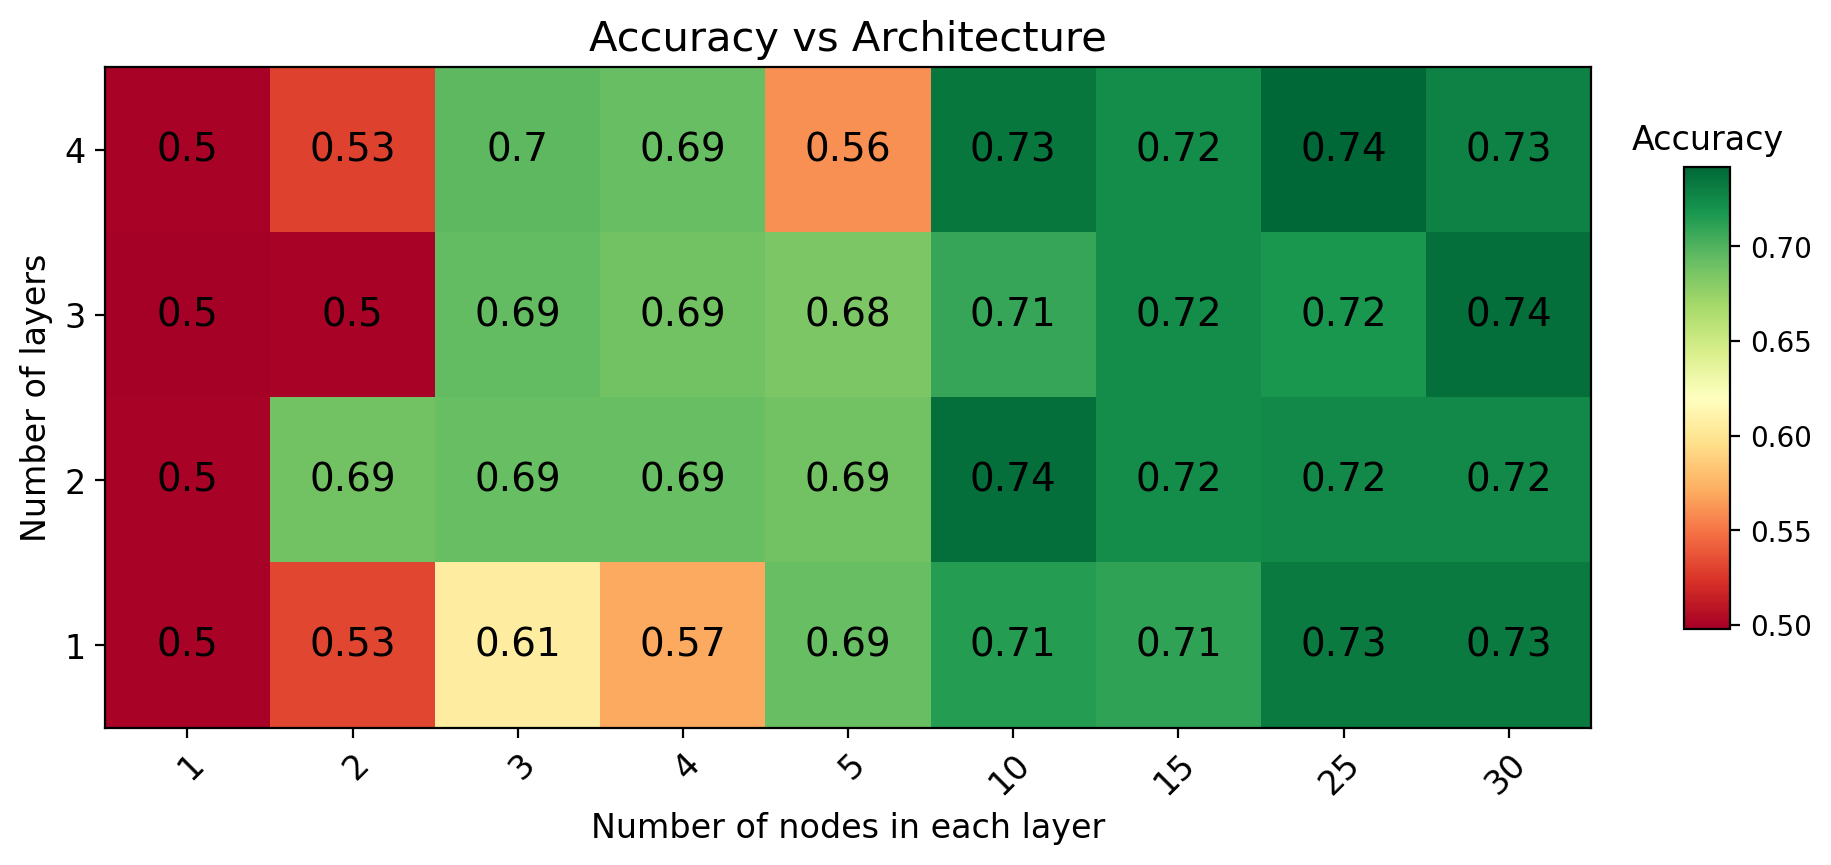

In [16]:
# prepare data for heatmap plotting
num_layers = ['4', '3', '2', '1']
num_nodes = ['1', '2', '3', '4', '5', '10', '15', '25', '30']
# append 4 lists into 1 list
l_scores_architecture = []
for i in [l_scores_layer4, l_scores_layer3, l_scores_layer2, l_scores_layer1]:
    l_scores_architecture.append(i)

# start plotting
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(l_scores_architecture, cmap='RdYlGn')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(num_nodes)), labels=num_nodes, fontsize=12)
ax.set_yticks(np.arange(len(num_layers)), labels=num_layers, fontsize=12)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add a color bar to the heatmap
colorbar = plt.colorbar(im, aspect=10, shrink=0.3)
# Set the title of the color bar
colorbar.ax.set_title('Accuracy')

# Loop over data dimensions and create text annotations.
for i in range(len(num_layers)):
    for j in range(len(num_nodes)):
        text = ax.text(j, i, round(l_scores_architecture[i][j], 2),
                       fontsize=14, ha="center", va="center", color="k")
ax.set_title("Accuracy vs Architecture", fontsize=15)
ax.set_xlabel('Number of nodes in each layer', fontsize=12)
ax.set_ylabel('Number of layers', fontsize=12)
fig.tight_layout()
plt.show()

According to the heatmap, as the number of nodes per layer and number of layers increase, the accuracy will generally increase. But simply increasing number of layers or increasing number of layers doesn't necessarily increase model accuracy. When the number of layers is small, increasing the number of nodes per layer even decreases the accuracy. This might be the reason that the model becomes too complex and starts to overfit.\
Since a simpler model is preferred in terms of variance, I chose the architecture with **2 hidden layers and 10 nodes in each layer**, which achieves the 74% accuracy on the validation data.

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

------------------------------------------------------------------
ANSWER:

In [17]:
# train model with optimized hyperparameters on all training data
mlp_best = new_init_MLP(hidden_layer_sizes = (10,10))
mlp_best.fit(X_train_plus_val, y_train_plus_val)

# test model on test data
print(f'Accuracy on test data is {mlp_best.score(X_test, y_test):.2f}')

Accuracy on test data is 0.73


The accuracy of final model on test data is 0.73. \
The ROC curve is plotted in the next section.

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

------------------------------------------------------------------
ANSWER:

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [18]:
mlp = MLPClassifier(solver = 'sgd',
                    tol = 1e-5,
                    early_stopping = False,
                    activation = 'relu',
                    n_iter_no_change = 1000,
                    max_iter = 500,
                    random_state = 225)

l_architecture = l_layer1 + l_layer2 + l_layer3 + l_layer4
param_dist = {
    "hidden_layer_sizes": l_architecture,
    "learning_rate_init": loguniform(1e-5, 1e0),
    "alpha": loguniform(1e-8, 1e2),
    "batch_size": [1, 3, 5, 10, 20, 50, 100, 250, 500]
}

random_search = RandomizedSearchCV(
    mlp, param_distributions=param_dist, n_iter=200, \
        cv =train_val_split, n_jobs=-1, random_state=42)

random_search.fit(X_train_plus_val, y_train_plus_val)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=MLPClassifier(max_iter=500, n_iter_no_change=1000,
                                           random_state=225, solver='sgd',
                                           tol=1e-05),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025DF07E1420>,
                                        'batch_size': [1, 3, 5, 10, 20, 50, 100,
                                                       250, 500],
                                        'hi...1,), (2,), (3,),
                                                               (4,), (5,),
                                                               (10,), (15,),
                                                               (25,), (30,),
                                                               (1, 1), (2, 2),
                                                               (3, 3), (4, 4),
                                                               (5, 5), (10, 10),
                                                               (15, 15),
                                                               (25, 25),
                                                               (30, 30),
                                                               (1, 1, 1),
                                                               (2, 2, 2),
                                                               (3, 3, 3),
                                                               (4, 4, 4),
                                                               (5, 5, 5),
                                                               (10, 10, 10),
                                                               (15, 15, 15),
                                                               (25, 25, 25),
                                                               (30, 30, 30),
                                                               (1, 1, 1, 1),
                                                               (2, 2, 2, 2),
                                                               (3, 3, 3, 3), ...],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025DF9AE6950>},
                   random_state=42)

In [19]:
random_search.best_params_

{'alpha': 1.2877252667142131e-05,
 'batch_size': 250,
 'hidden_layer_sizes': (25, 25, 25, 25),
 'learning_rate_init': 0.009046673956058786}

In [20]:
print(f'The best accuracy is {random_search.best_score_:.2f}\
       with the following parameters:')
print(f"alpha: {random_search.best_params_['alpha']:.2f}")
print(f"batch size: {random_search.best_params_['batch_size']:.2f}")
print(f"hidden layer sizes: {random_search.best_params_['hidden_layer_sizes']}")
print(f"learning rate: {random_search.best_params_['learning_rate_init']:.2f}")

The best accuracy is 0.74 with the following parameters:
alpha: 0.00
batch size: 250.00
hidden layer sizes: (25, 25, 25, 25)
learning rate: 0.01


In [19]:
import pickle
import os 
os.chdir('F:/Duke MIDS/705_ML/Assignment/04')

In [22]:
# save the model to disk for reuse
filename = 'random_search_model.pkl'
pickle.dump(random_search, open(filename, 'wb'))

In [20]:
# load the model from disk
random_search = pickle.load(open('random_search_model.pkl', 'rb'))

- State the accuracy of the optimized models on the test dataset

In [21]:
print(f'Accuracy on test data from manual search is \
      {mlp_best.score(X_test, y_test):.4f}')
print(f'Accuracy on test data from random search is \
      {random_search.score(X_test, y_test):.4f}')

Accuracy on test data from manual search is 0.7300
Accuracy on test data from random search is 0.7360


- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search

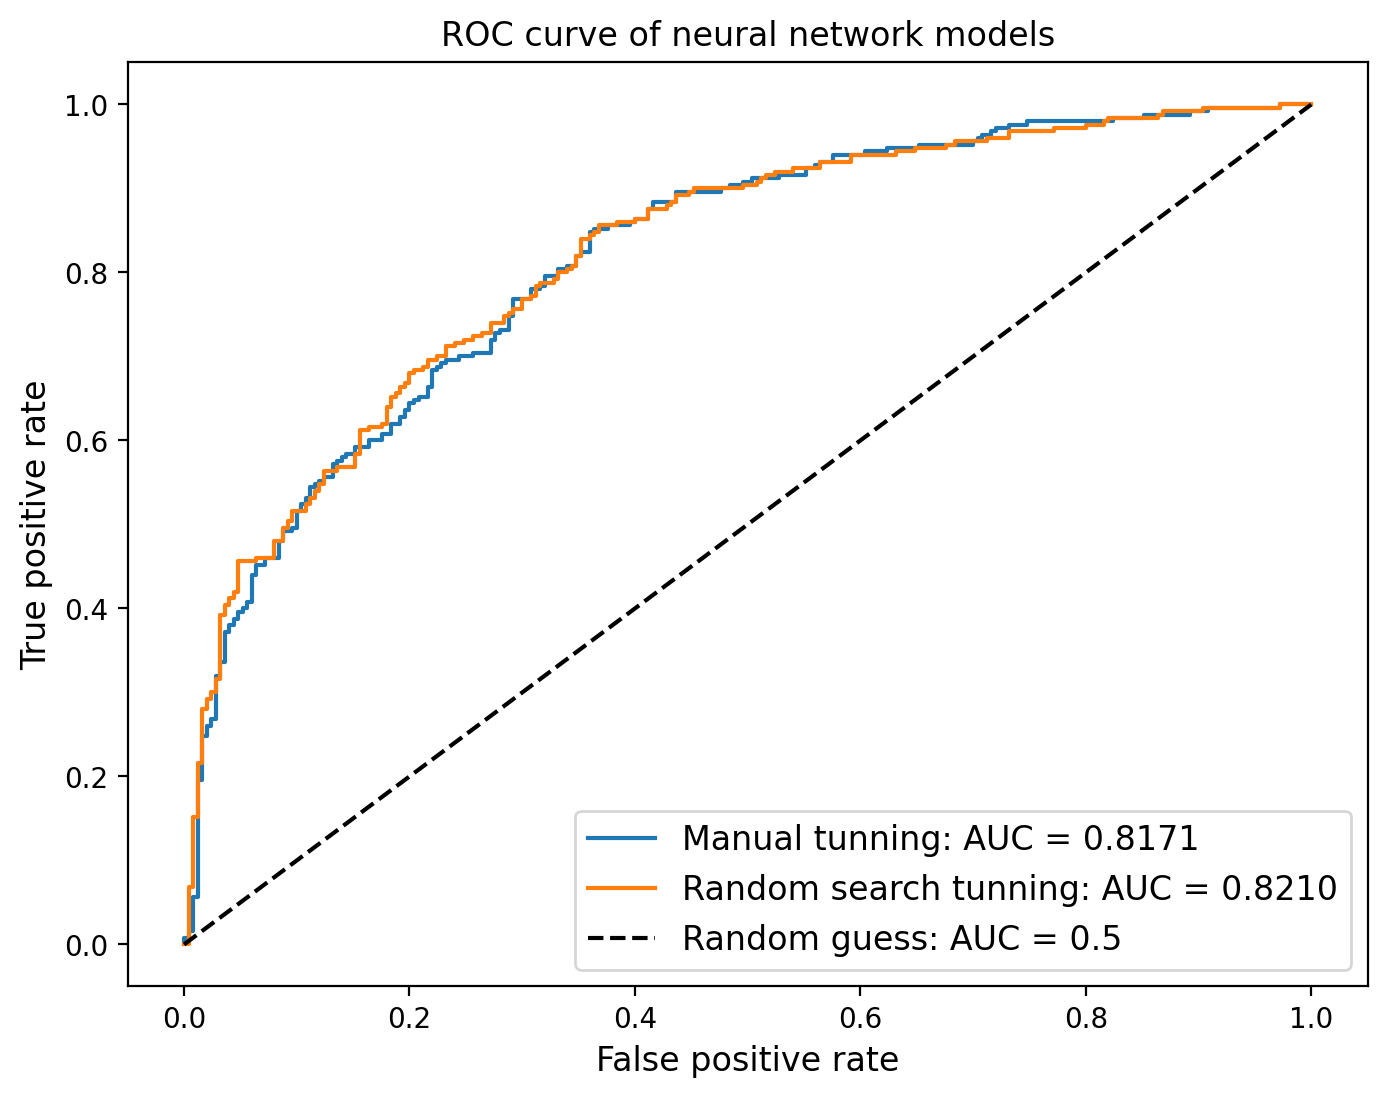

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_m, tpr_m, _ = roc_curve(y_test, mlp_best.predict_proba(X_test)[:,1])
fpr_RS, tpr_RS, _ = roc_curve(y_test, random_search.predict_proba(X_test)[:,1])
auc_m = roc_auc_score(y_test, mlp_best.predict_proba(X_test)[:,1])
auc_RS = roc_auc_score(y_test, random_search.predict_proba(X_test)[:,1])

# plot the ROC curve
plt.figure(figsize=(8,6), dpi=100)
plt.plot(fpr_m, tpr_m, label=f'Manual tunning: AUC = {auc_m:.4f}')
plt.plot(fpr_RS, tpr_RS, label=f'Random search tunning: AUC = {auc_RS:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess: AUC = 0.5')
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.title('ROC curve of neural network models')
plt.legend(fontsize=12)
plt.show()

- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset.

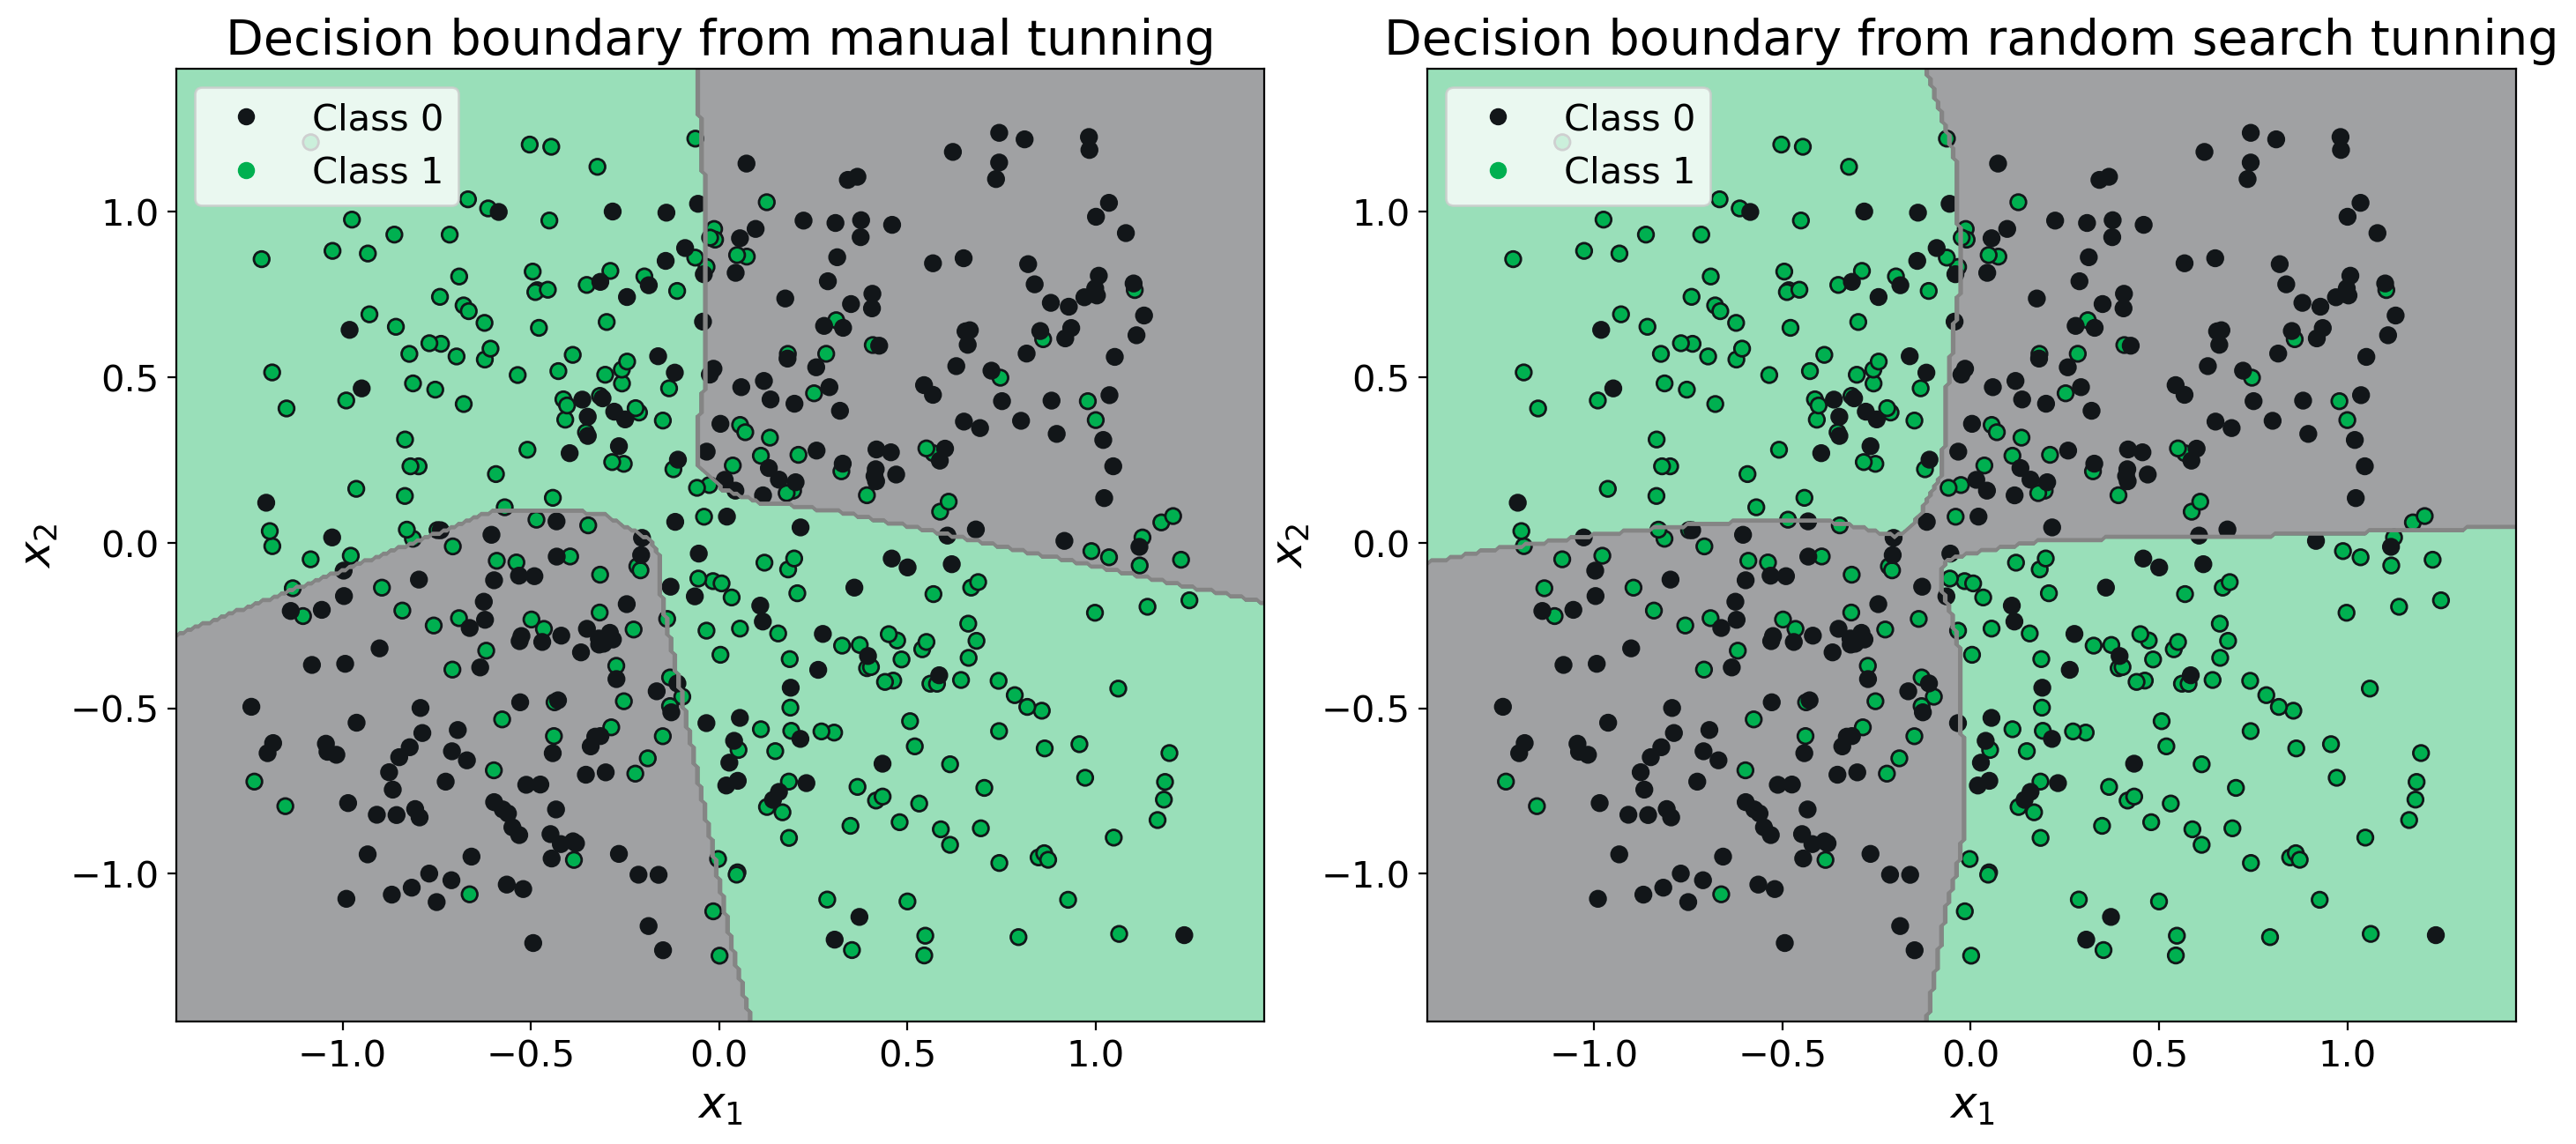

In [24]:
# prepare data for plot
l_xx = []
l_yy = []
l_zz = []
l_mlp = [mlp_best, random_search] # list of models
l_title = ['Decision boundary from manual tunning', \
           'Decision boundary from random search tunning']

x_min, x_max = X_test[:, 0].min() - 0.2, X_test[:, 0].max() + 0.2
y_min, y_max = X_test[:, 1].min() - 0.2, X_test[:, 1].max() + 0.2
xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.01),
                               np.arange(y_min, y_max, 0.01))
xx_yy = np.c_[xx_test.ravel(), yy_test.ravel()]

for mlp in l_mlp:
    Z_test = mlp.predict(xx_yy)
    Z_test = np.array(Z_test).reshape(xx_test.shape)
    l_xx.append(xx_test)
    l_yy.append(yy_test)
    l_zz.append(Z_test)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
fig.tight_layout()
fig.subplots_adjust(wspace=0.15)
for ax, xx, yy, zz, title in zip(axs.flat, l_xx, l_yy, l_zz, l_title):
    ax.contour(xx, yy, zz, colors='#858585', linewidths=0.5)
    ax.contourf(xx, yy, zz, alpha=0.4, cmap=cust_cmap)
    scatter = ax.scatter(X_test[:, 0], X_test[:, 1], cmap=cust_cmap, \
                         c=y_test, edgecolors='#121619', s=40)
    ax.legend(handles=scatter.legend_elements()[0], 
                 labels=['Class 0', 'Class 1'], fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('$x_1$', fontsize = 18)
    ax.set_ylabel('$x_2$', fontsize = 18)
    ax.tick_params(axis='both', labelsize=15)

The generalization performance of hyperparameters selected by **random search is slightly better than greedy search**. The AUC of random search is 0.8210, while the AUC of greedy search is 0.8171. In terms of accuracy, the random search model achieves 0.7360, while the greedy search model achieves 0.7300. This might be the reason that random search algorithms explores the search space more thoroughly and therefore has a better chance of finding the global optimum.

# 2

## [35 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [10 points of the 35]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: Due to the depth this question requires, some students may choose not to complete this section (in lieu of receiving the 10 points from this question). If you choose not to build your own neural network, or if your neural network is not functional prior to submission, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead.**

In [1]:
# neural network class skeleton code

class myNeuralNetwork(object):
    
    def __init__(self, random_state, n_in, n_layer1=5, \
                 n_layer2=5, n_out=1, learning_rate=0.01, epoch=500):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs (bias term is included)
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
                epoch:         number of epochs to train the model
                random_state:  random seed for initializing weights
            Output:
                none
        '''
        self.n_in = n_in 
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.random_state = random_state

        # initialize weights 
        np.random.seed(self.random_state)
        self.W1 = np.random.randn(self.n_in, self.n_layer1)
        self.W2 = np.random.randn(self.n_layer1, self.n_layer2)
        self.W3 = np.random.randn(self.n_layer2, self.n_out)
        return None
    

    def sigmoid(self, x):
        '''
        Calculate the sigmoid function of x
        Input: x
        Output: the value of the sigmoid
        '''
        return 1/(1+np.exp(-x))
    
    def sigmoid_derivative(self, x):
        '''
        Calculate the derivative of the sigmoid function
        Input: x
        Output: the value of the sigmoid derivative
        '''
        return self.sigmoid(x)*(1-self.sigmoid(x))

    def forward_propagation(self, X):
        '''forward_propagation
        Runs the input data through the network to generate predictions
        based on the current weights of the network. This method should
        use the sigmoid function as the activation function for each
        layer.
        Input:
            X: A matrix of N samples of data [N x n_in]
        Output:
            a1, z1, a2, z2, a3, z3: The activations and outputs of each layer
        '''
        # calculate activations for layer 1
        a1 = np.matmul(X, self.W1)
        z1 = self.sigmoid(a1)

        # calculate activations for layer 2
        a2 = np.matmul(z1, self.W2)
        z2 = self.sigmoid(a2)

        # calculate activations for output layer
        a3 = np.matmul(z2, self.W3)
        z3 = self.sigmoid(a3)
        return a1, z1, a2, z2, a3, z3

    
    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
        Input:
            X: A matrix of N samples of data [N x n_in]
            y: Target variable [N x 1]
        Output:
            loss: a scalar measure of loss/cost
        '''
        _, _, _, _, _, z3 = self.forward_propagation(X)
        loss = np.mean((z3 - y)**2)/2
        return loss

    
    def backpropagate(self, X, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
        Input:
            X: A matrix of N samples of data [N x n_in] 
            y: Target variable [scalar]
        Output:
            loss: a scalar measure of th loss/cost associated with x,y
            and the current model weights
        '''
        # forward pass
        a1, z1, a2, z2, a3, z3 = self.forward_propagation(X)
        loss = self.compute_loss(X, y)

        # backward propagation
        delta3 = (z3 - y) * self.sigmoid_derivative(a3).reshape(-1,1)
        delta2 = np.matmul(delta3, self.W3.T) * self.sigmoid_derivative(a2)
        delta1 = np.matmul(delta2, self.W2.T) * self.sigmoid_derivative(a1)

        # compute gradients
        dW3 = np.matmul(z2.T, delta3)
        dW2 = np.matmul(z1.T, delta2)
        dW1 = np.matmul(X.T, delta1)

        # update weights
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2
        self.W3 -= self.learning_rate * dW3

        return loss
    
    
    def fit(self, Xtrain, ytrain, Xval=None, yval=None, max_epochs=2000, \
            learning_rate=0.01, get_validation_loss=False):
        '''fit
        Input:
            X: A matrix of N samples of data [N x n_in+1] (with bias term)
            y: Target variable [N x 1]
        Output:
            training_loss:   Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch
                            [optional output if get_validation_loss==True]
        '''
        self.learning_rate = learning_rate
        self.epoch = max_epochs

        training_loss = []
        validation_loss = []
        for _ in range(max_epochs):
            # random shuffle the training data
            idx = np.random.permutation(Xtrain.shape[0])
            Xtrain = Xtrain[idx]
            ytrain = ytrain[idx]
            
            # start training
            train_loss = self.backpropagate(Xtrain, ytrain)
            training_loss.append(train_loss)
            if get_validation_loss:
                validation_loss.append(self.compute_loss(Xval, yval))
        return training_loss, validation_loss
            
    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        _, _, _, _, _, z3 = self.forward_propagation(X)
        return z3
    
    def predict(self, X, decision_thresh=0.5):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
        y_hat = self.predict_proba(X)
        y_pred_class = [1 if i > decision_thresh else 0 for i in y_hat]
        return np.array(y_pred_class)

    def accuracy(self, y_hat, y):
        '''
        Compute the accuracy of the model's predictions
        Input:
            y_hat: A vector of class predictions of either 0 or 1 [N x 1]
            y: A vector of class labels of either 0 or 1 [N x 1]
        Output:
            accuracy: A scalar between 0 and 1 representing the accuracy of the model
        '''
        correct = 0
        for i in range(len(y)):
            if y[i] == y_hat[i]:
                correct += 1
        return correct / float(len(y))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

**(b)** Apply your neural network. 
- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.
- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 
- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead.*

Note if you opted not to build your own neural network: in this case, for hyperparameter tuning, we recommend using the `partial_fit` method to train your model for every epoch. Partial fit allows you to incrementally fit on one sample at a time.



In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# create training data
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
Xtest, ytest = make_moons(n_samples=100, noise=0.2, random_state=42)

# split into training and validation sets
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# add bias term to input data
Xtrain_ = np.hstack((np.ones((Xtrain.shape[0], 1)), Xtrain))
Xval_ = np.hstack((np.ones((Xval.shape[0], 1)), Xval))
Xtest_ = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))
X_ = np.hstack((np.ones((X.shape[0], 1)), X))   # train + val

# reshape y to be a column vector
ytrain_ = ytrain.reshape(-1,1)
yval_ = yval.reshape(-1,1)
ytest_ = ytest.reshape(-1,1)
y_ = y.reshape(-1,1)   # train + val

In [5]:
# initialize model
myNN = myNeuralNetwork(n_in=Xtrain_.shape[1], random_state=42)

# train model
train_loss, val_loss = myNN.fit(Xtrain_, ytrain_, Xval_, yval_, \
                                max_epochs=3000, learning_rate=0.01, \
                                get_validation_loss=True)

- **Cost function plots**. 

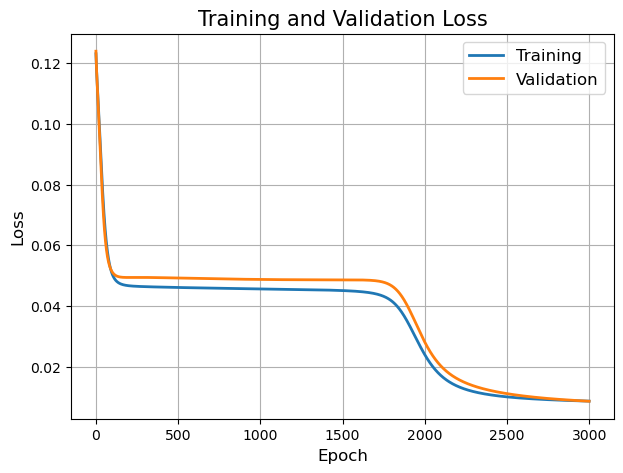

In [6]:
plt.figure(figsize=(7,5), dpi=100)
plt.grid('on')
plt.plot(train_loss, label='Training', linewidth=2)
plt.plot(val_loss, label='Validation', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=15)
plt.legend(fontsize=12)
plt.show()

- **Tune the learning rate and number of training epochs to improve performance as needed**

Here I performed **grid search** to tune the learning rate and number of training epochs. 
- Learning rate: logarithmically from $10^−5$ to $10^0$ with 21 steps
- Number of training epochs: from 500 to 4000 with 21 steps

In [7]:
def grid_search_NN(Xtrain, ytrain, Xval, yval, l_lr, l_epochs, random_state):
        """
        Grid search for hyperparameter tuning
        """
        # initialize the best hyperparameters
        best_learning_rate = l_lr[0]
        best_max_epochs = l_epochs[0]
        best_accuracy = 0
        # loop through all hyperparameters
        for learning_rate in l_lr:
            for max_epochs in l_epochs:
                # train model
                model = myNeuralNetwork(n_in=Xtrain.shape[1], random_state=random_state)
                model.fit(Xtrain, ytrain, Xval, yval, learning_rate=learning_rate, \
                         max_epochs=max_epochs, get_validation_loss=False)
                # get accuracy on validation data
                yhat = model.predict(Xval)
                accuracy = model.accuracy(yhat, yval)
                # update the best hyperparameters
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_learning_rate = learning_rate
                    best_max_epochs = max_epochs
        # return the best hyperparameters
        return best_learning_rate, best_max_epochs, best_accuracy

In [8]:
l_lr = np.logspace(-5, 0, 21)
l_epochs = [int(i) for i in np.linspace(500, 4000, 21)]
best_learning_rate, best_max_epochs, best_accuracy = grid_search_NN(Xtrain_, ytrain_, \
                                        Xval_, yval_, l_lr, l_epochs, random_state=42)
print(f'Best learning rate: {best_learning_rate}')
print(f'Best max epochs: {best_max_epochs}')
print(f'Best accuracy: {best_accuracy}')

Best learning rate: 0.01
Best max epochs: 2600
Best accuracy: 0.99


The best parameters after grid search is: **learning rate = 0.01, number of training epochs = 2600**. The best score reaches 0.99.

- **Decision boundary plots**.

In [9]:
# train model with best hyperparameters
myNN = myNeuralNetwork(n_in=Xtrain_.shape[1], random_state=42)
_, _ = myNN.fit(Xtrain_, ytrain_, Xval_, yval_, 
                max_epochs=2600, learning_rate=0.01, \
                get_validation_loss=False)

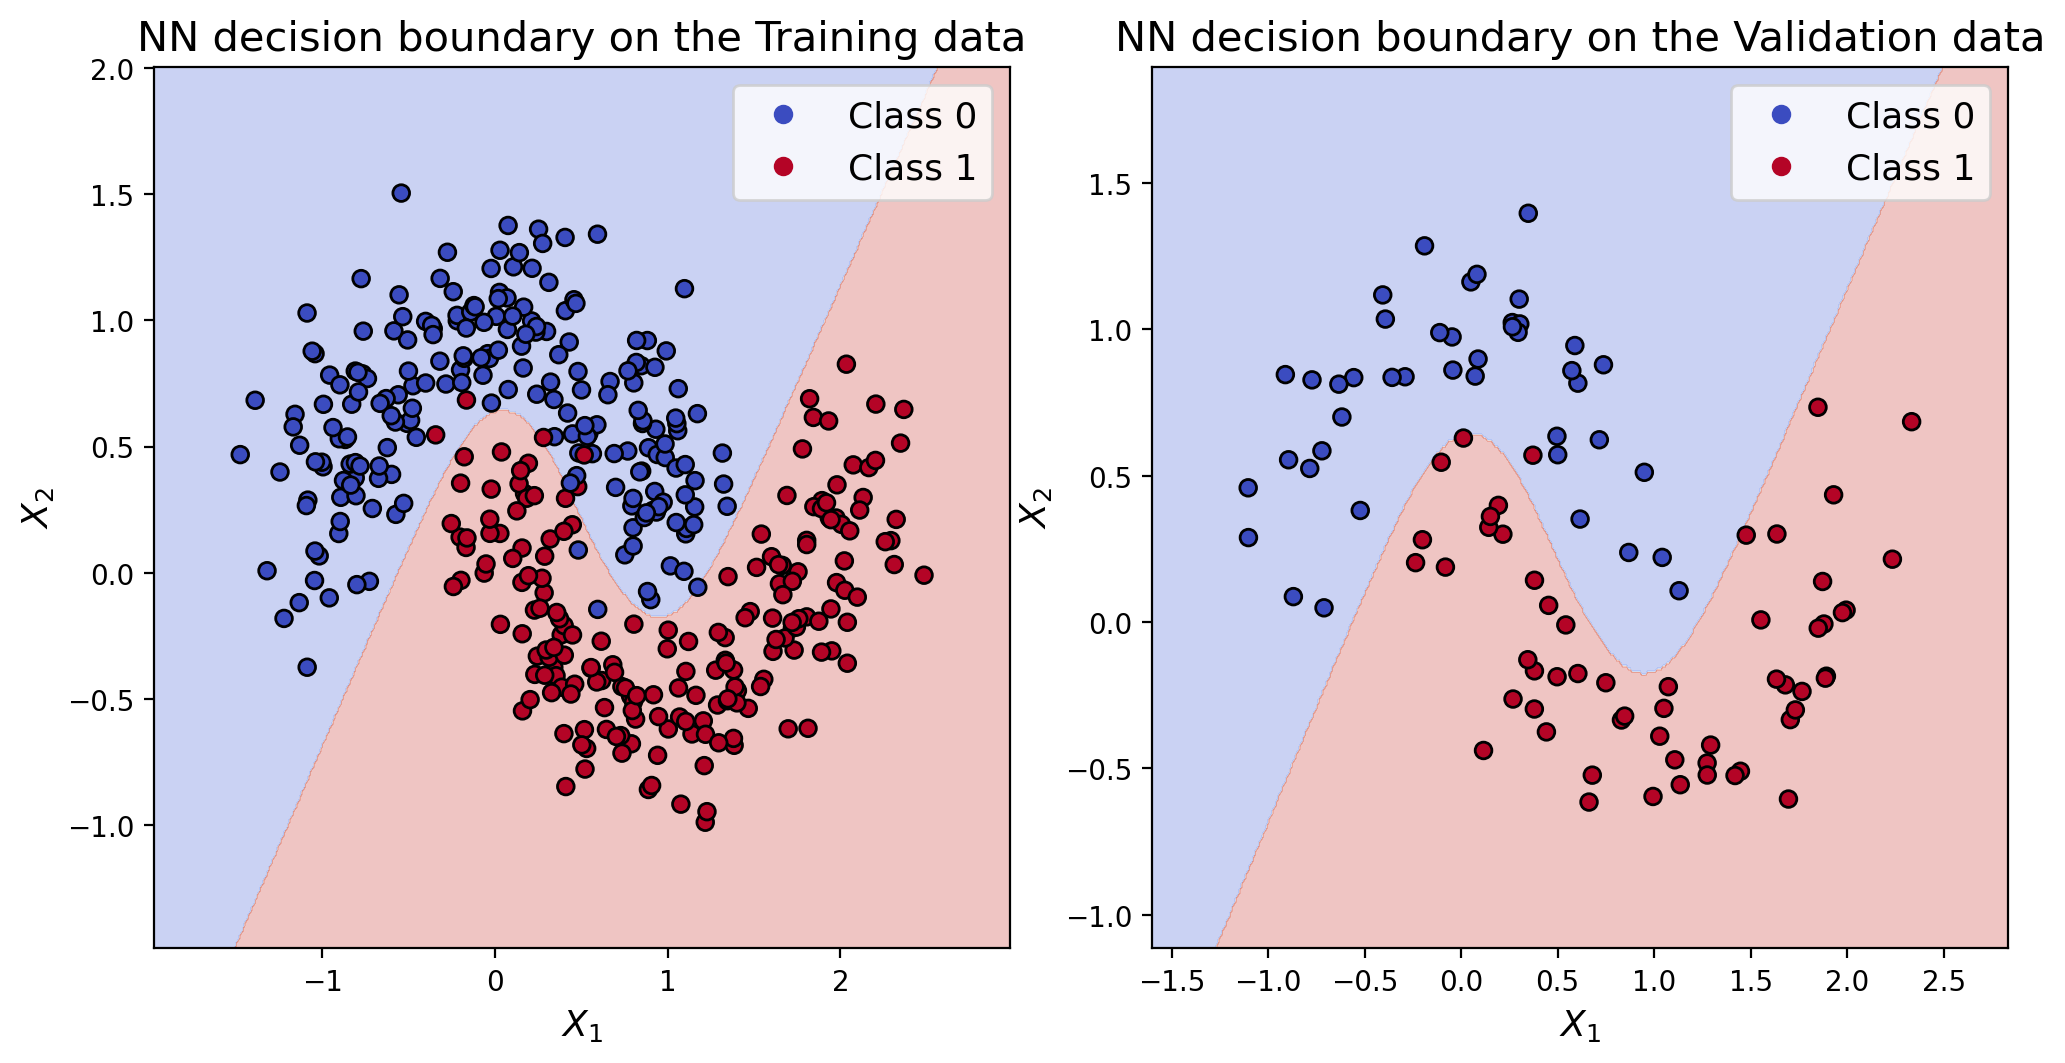

In [12]:
# Prepare for plotting training data
##### note the first column of X is all ones ######
x_min, x_max = Xtrain_[:, 1].min() - 1, Xtrain_[:, 1].max() + 1
y_min, y_max = Xtrain_[:, 2].min() - 1, Xtrain_[:, 2].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
xx_yy = np.c_[xx_train.ravel(), yy_train.ravel()]
xx_yy = np.hstack((np.ones((xx_yy.shape[0], 1)), xx_yy))
Z_train = myNN.predict(xx_yy)
Z_train = np.array(Z_train).reshape(xx_train.shape)

# Prepare for plotting validation data
x_min, x_max = Xval_[:, 1].min() - 1, Xval_[:, 1].max() + 1
y_min, y_max = Xval_[:, 2].min() - 1, Xval_[:, 2].max() + 1

xx_val, yy_val = np.meshgrid(np.arange(x_min, x_max, 0.01),
                               np.arange(y_min, y_max, 0.01))
xx_yy = np.c_[xx_val.ravel(), yy_val.ravel()]
xx_yy = np.hstack((np.ones((xx_yy.shape[0], 1)), xx_yy))
Z_val = myNN.predict(xx_yy)
Z_val = np.array(Z_val).reshape(xx_val.shape)

# wrap into lists
list_X = [Xtrain_, Xval_]
list_y = [ytrain_, yval_]
list_xx = [xx_train, xx_val]
list_yy = [yy_train, yy_val]
list_Z = [Z_train, Z_val]
list_title = ['Training data', 'Validation data']

# Plot the decision boundary of training and test data
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi= 100)
fig.tight_layout(w_pad=2)
for i in range(2):
    # plot the decision boundary
    ax[i].contourf(list_xx[i], list_yy[i], list_Z[i],
                   cmap=plt.cm.coolwarm, alpha=0.3)
    # plot the data
    scatter = ax[i].scatter(list_X[i][:, 1], list_X[i][:, 2],
                            c=list_y[i], cmap=plt.cm.coolwarm, edgecolor='black')
    # set plot attributes
    ax[i].legend(handles=scatter.legend_elements()[0], 
                 labels=['Class 0', 'Class 1'], fontsize = 13)
    ax[i].set_xlabel('$X_1$', fontsize = 13)
    ax[i].set_ylabel('$X_2$', fontsize = 13)
    ax[i].set_xlim(list_X[i][:, 1].min()-0.5, list_X[i][:, 1].max()+0.5)
    ax[i].set_ylim(list_X[i][:, 2].min()-0.5, list_X[i][:, 2].max()+0.5)
    ax[i].set_title(f'NN decision boundary on the {list_title[i]}', fontsize = 15)
plt.show()

- **ROC Curve plots**

**Self-defined neural network:**

In [34]:
# train model with best hyperparameters on train + val
myNN_best = myNeuralNetwork(n_in=X_.shape[1], random_state=42)
_, _ = myNN_best.fit(X_, y_, max_epochs=2600, learning_rate=0.01, \
                     get_validation_loss=False)

# prepare data for roc curve on test data
fpr_myNN, tpr_myNN, _ = roc_curve(ytest, myNN_best.predict_proba(Xtest_))
auc_myNN = roc_auc_score(ytest, myNN_best.predict_proba(Xtest_))

**MLP Classifier from sklearn:**

In [35]:
mlp_ii = MLPClassifier(hidden_layer_sizes=(5,5), \
                       activation='logistic', \
                       solver='sgd', \
                       max_iter=2600, \
                       tol=1e-10,
                       early_stopping=False,
                       n_iter_no_change=300,
                       batch_size=1,
                       learning_rate_init=0.01, 
                       random_state=42)
mlp_ii.fit(X, y)
fpr_mlp, tpr_mlp, _ = roc_curve(ytest, mlp_ii.predict_proba(Xtest)[:, 1])
auc_mlp = roc_auc_score(ytest, mlp_ii.predict_proba(Xtest)[:, 1])

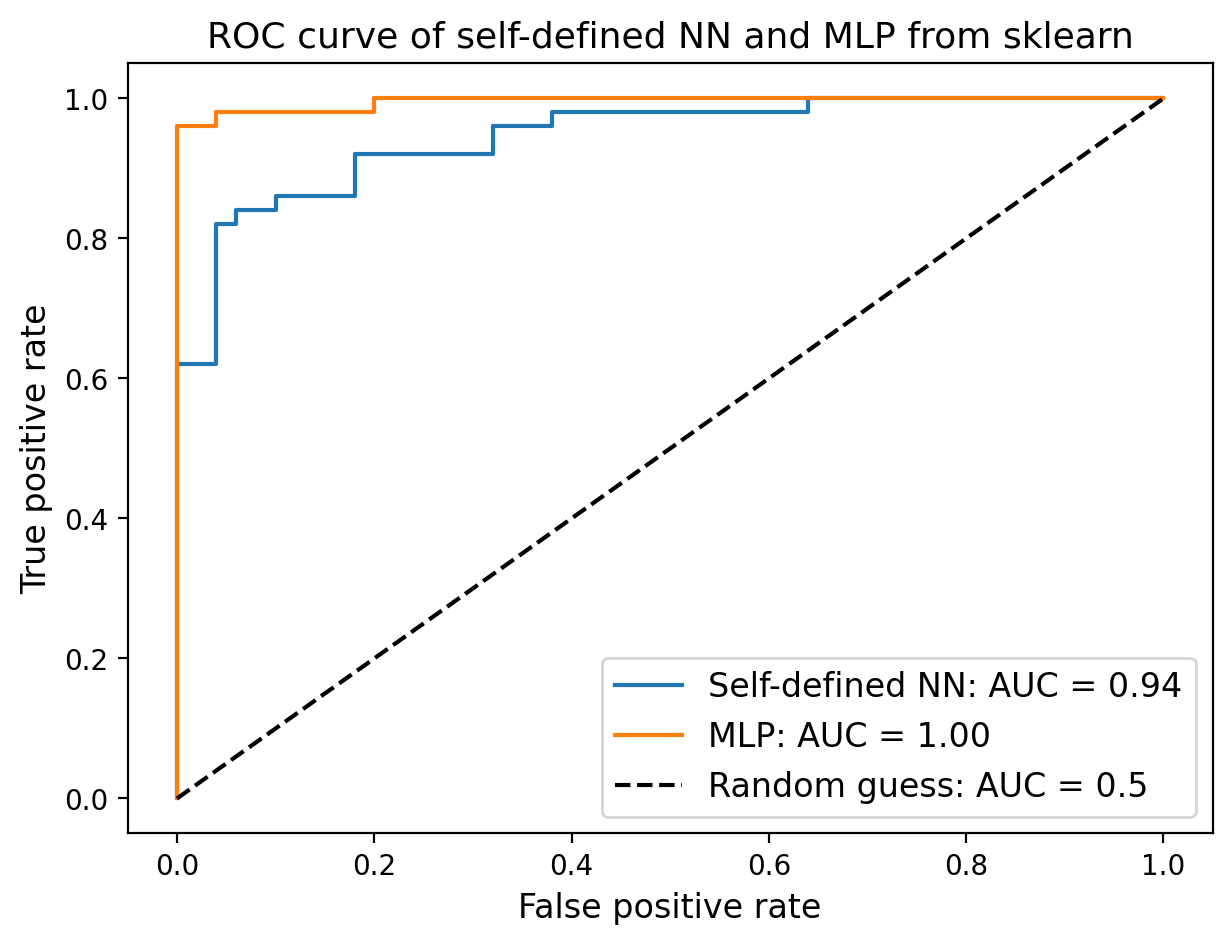

In [36]:
# plot the ROC curve
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(fpr_myNN, tpr_myNN, label=f'Self-defined NN: AUC = {auc_myNN:.2f}')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP: AUC = {auc_mlp:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess: AUC = 0.5')
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.title('ROC curve of self-defined NN and MLP from sklearn', fontsize=13)
plt.legend(fontsize=12)
plt.show()

The auc score of self-defined NN is 0.94, which is lower than the MLP classifier from sklearn with the same parameters.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

- Use **regularization** techniques: Regularization techniques such as L1 and L2 regularization or dropout can help prevent overfitting, which helps improve model performance.
- Change **activation function** to **ReLU**: ReLU is a more efficient activation function than sigmoid. It is also more robust to outliers and can help solve the vanishing gradient problem.
- Add **more training data**: More training data can help improve model performance.